In this notebook, I will look at the average heterozygosity on X and the autosomes.

In [1]:
%run ../scripts/notebook_settings.py

In [2]:
meta_data_samples = pd.read_table("../data/metadata_with_x_missing.txt", sep=" ")
chromosomes = [f'chr{x}' for x in range(1, 21)] + ['chrX']

If I should employ masking for the size/het state, I should probably transform the positions into a boolean mask based on the bed file / masked fasta.
Assuming that X is harder to sequence in females than males is not certain - check the callmask you have generated.

In [3]:
females = meta_data_samples.loc[meta_data_samples.Sex == "F"][6:].reset_index()
mask_dir = "/home/eriks/primatediversity/people/erik/data/callmasks/"
het_list = []
chr_list = []
size_list = []
ID_list = []
cluster_list = []
for chrom in chromosomes:
    zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/{}".format(chrom)
    callset = zarr.open_group(zarr_dir, mode="r")
    gt_zarr = allel.GenotypeArray(callset["calldata/GT"])
    gt_zarr = gt_zarr.take(females.callset_index.values, axis=1)
    het_state = gt_zarr.is_het()
    for i, row in females.iterrows():
        het_list.append(het_state[:, i].sum())
        df = pd.read_csv(mask_dir+"{}/{}_mask.bed".format(row.PGDP_ID, chrom), sep='\t',
                             comment='t', header=None, names=["chrom", "chromStart", "chromEnd"])
        size = df.chromEnd.sum()-df.chromStart.sum()
        chr_list.append(chrom)
        size_list.append(size)
        ID_list.append(row.PGDP_ID)
        cluster_list.append(row.C_origin)
    print(chrom)
d = {"PGDP_ID": ID_list, "chrom": chr_list, "het_total": het_list, "chr_size": size_list, "C_origin": cluster_list}
het_df = pd.DataFrame(data=d)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chrX


In [4]:
het_df["het_rate"] = het_df["het_total"]/het_df["chr_size"]

In [5]:
comp_chr = "chr7"
het_autosome_list = []
het_x_list = []
comp_chr_list = []
ID_list = []
cluster_list = []
for ID in het_df.PGDP_ID.unique():
    ID_df = het_df.loc[het_df.PGDP_ID == ID]
    other_autosomes = ID_df.loc[(ID_df.chrom != "chrX") & (ID_df.chrom != comp_chr)]
    het_autosome_list.append(other_autosomes["het_total"].sum()/(other_autosomes["chr_size"].sum()))
    chr_x = ID_df.loc[(ID_df.chrom == "chrX")]
    het_x_list.append(chr_x["het_total"].sum()/(chr_x["chr_size"].sum()))
    chr_comp = ID_df.loc[(ID_df.chrom == comp_chr)]
    comp_chr_list.append(chr_comp["het_total"].sum()/(chr_comp["chr_size"].sum()))
    ID_list.append(ID)
    cluster_list.append(ID_df.C_origin.unique()[0])
d = {"PGDP_ID": ID_list, "autosomal_het": het_autosome_list, "chrX_het": het_x_list,
     comp_chr+"_het": comp_chr_list, "C_origin": cluster_list}
chrX_vs_autosomes = pd.DataFrame(data=d)
chrX_vs_autosomes["X_autosome_ratio"] = chrX_vs_autosomes["chrX_het"]/chrX_vs_autosomes["autosomal_het"]
chrX_vs_autosomes["X_comp_ratio"] = chrX_vs_autosomes["chrX_het"]/chrX_vs_autosomes[comp_chr+"_het"]

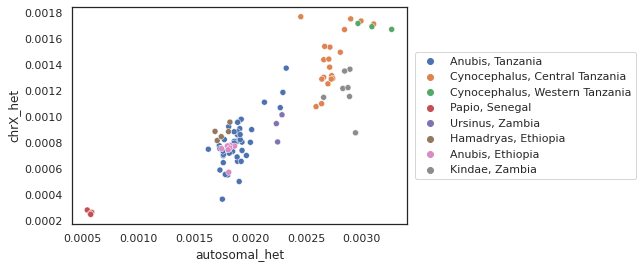

In [6]:
g = sns.scatterplot(data=chrX_vs_autosomes, x="autosomal_het", y="chrX_het", hue = "C_origin")
g.legend(loc='center right', bbox_to_anchor=(1.7, 0.5))

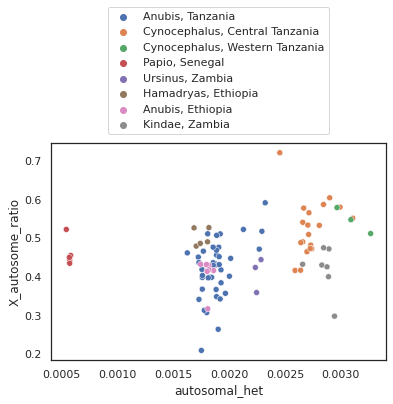

In [7]:
g = sns.scatterplot(data=chrX_vs_autosomes, x="autosomal_het", y="X_autosome_ratio", hue = "C_origin")
g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.65))

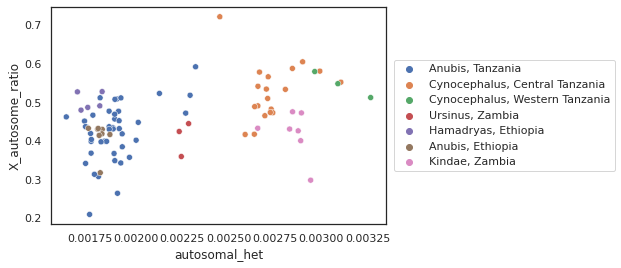

In [8]:
g = sns.scatterplot(data=chrX_vs_autosomes.loc[chrX_vs_autosomes.C_origin != "Papio, Senegal"],
                   x="autosomal_het", y="X_autosome_ratio", hue = "C_origin")
g.legend(loc='center right', bbox_to_anchor=(1.7, 0.5))

In [9]:
chrX_vs_autosomes.loc[chrX_vs_autosomes.X_autosome_ratio < 0.3]

,PGDP_ID,autosomal_het,chrX_het,chr7_het,C_origin,X_autosome_ratio,X_comp_ratio
15,PD_0222,0.001750,0.000366,0.001570,"Anubis, Tanzania",0.209094,0.233086
38,PD_0499,0.001901,0.000502,0.001791,"Anubis, Tanzania",0.263958,0.280224
88,PD_0788,0.002943,0.000877,0.002855,"Kindae, Zambia",0.297892,0.307097


In [10]:
chrX_vs_autosomes.loc[chrX_vs_autosomes.X_autosome_ratio > 0.6]

,PGDP_ID,autosomal_het,chrX_het,chr7_het,C_origin,X_autosome_ratio,X_comp_ratio
10,PD_0213,0.002900,0.001754,0.002954,"Cynocephalus, Central Tanzania",0.604827,0.593617
41,PD_0503,0.002453,0.001770,0.003034,"Cynocephalus, Central Tanzania",0.721688,0.583515


In [11]:
females = meta_data_samples.loc[meta_data_samples.Sex == "F"][6:].reset_index()
mask_dir = "/home/eriks/primatediversity/people/erik/data/callmasks/"
het_list = []
chr_list = []
size_list = []
ID_list = []
cluster_list = []
for chrom in chromosomes:
    zarr_dir = "/faststorage/project/baboondiversity/data/PG_panu3_zarr_12_03_2021/callset.zarr/{}".format(chrom)
    callset = zarr.open_group(zarr_dir, mode="r")
    gt_zarr = allel.GenotypeArray(callset["calldata/GT"])
    gt_zarr = gt_zarr.take(females.callset_index.values, axis=1)
    if chrom == "chrX":
        pos = allel.SortedIndex(callset['variants/POS'])
        loc_region = pos.locate_range(start=1500000)
        gt_zarr = gt_zarr[loc_region]
    het_state = gt_zarr.is_het()
    for i, row in females.iterrows():
        df = pd.read_csv(mask_dir+"{}/{}_mask.bed".format(row.PGDP_ID, chrom), sep='\t',
                             comment='t', header=None, names=["chrom", "chromStart", "chromEnd"])
        if chrom == "chrX":
            df = df.loc[df.chromStart > 1500000]
        size = df.chromEnd.sum()-df.chromStart.sum()
        het_list.append(het_state[:, i].sum())
        chr_list.append(chrom)
        size_list.append(size)
        ID_list.append(row.PGDP_ID)
        cluster_list.append(row.C_origin)
    print(chrom)
d = {"PGDP_ID": ID_list, "chrom": chr_list, "het_total": het_list, "chr_size": size_list, "C_origin": cluster_list}
het_df = pd.DataFrame(data=d)

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chrX


In [12]:
het_df["het_rate"] = het_df["het_total"]/het_df["chr_size"]

In [13]:
comp_chr = "chr7"
het_autosome_list = []
het_x_list = []
comp_chr_list = []
ID_list = []
cluster_list = []
for ID in het_df.PGDP_ID.unique():
    ID_df = het_df.loc[het_df.PGDP_ID == ID]
    other_autosomes = ID_df.loc[(ID_df.chrom != "chrX") & (ID_df.chrom != comp_chr)]
    het_autosome_list.append(other_autosomes["het_total"].sum()/(other_autosomes["chr_size"].sum()))
    chr_x = ID_df.loc[(ID_df.chrom == "chrX")]
    het_x_list.append(chr_x["het_total"].sum()/(chr_x["chr_size"].sum()))
    chr_comp = ID_df.loc[(ID_df.chrom == comp_chr)]
    comp_chr_list.append(chr_comp["het_total"].sum()/(chr_comp["chr_size"].sum()))
    ID_list.append(ID)
    cluster_list.append(ID_df.C_origin.unique()[0])
d = {"PGDP_ID": ID_list, "autosomal_het": het_autosome_list, "chrX_het": het_x_list,
     comp_chr+"_het": comp_chr_list, "C_origin": cluster_list}
chrX_vs_autosomes = pd.DataFrame(data=d)
chrX_vs_autosomes["X_autosome_ratio"] = chrX_vs_autosomes["chrX_het"]/chrX_vs_autosomes["autosomal_het"]
chrX_vs_autosomes["X_comp_ratio"] = chrX_vs_autosomes["chrX_het"]/chrX_vs_autosomes[comp_chr+"_het"]
chrX_vs_autosomes[comp_chr+"_autosome_ratio"] = chrX_vs_autosomes[comp_chr+"_het"]/chrX_vs_autosomes["autosomal_het"]

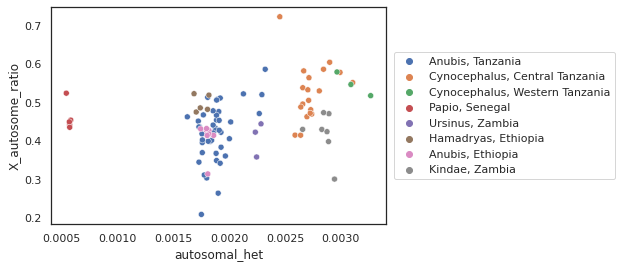

In [14]:
g = sns.scatterplot(data=chrX_vs_autosomes, x="autosomal_het", y="X_autosome_ratio", hue = "C_origin")
g.legend(loc='center right', bbox_to_anchor=(1.7, 0.5))

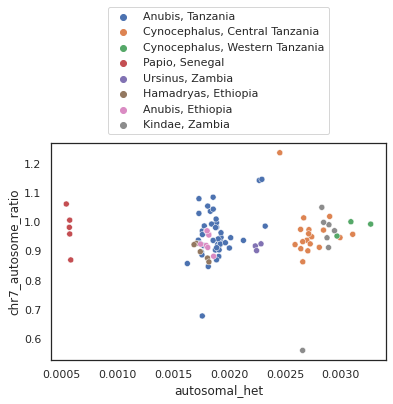

In [15]:
g = sns.scatterplot(data=chrX_vs_autosomes, x="autosomal_het", y=comp_chr+"_autosome_ratio", hue = "C_origin")
g.legend(loc='upper center', bbox_to_anchor=(0.5, 1.65))

In [16]:
chrX_vs_autosomes.loc[chrX_vs_autosomes.X_autosome_ratio < 0.35]

,PGDP_ID,autosomal_het,chrX_het,chr7_het,C_origin,X_autosome_ratio,X_comp_ratio,chr7_autosome_ratio
1,PD_0200,0.001887,0.000658,0.001852,"Anubis, Tanzania",0.348972,0.355419,0.981861
8,PD_0211,0.001798,0.000546,0.001731,"Anubis, Tanzania",0.303732,0.315559,0.962518
15,PD_0222,0.001750,0.000366,0.001570,"Anubis, Tanzania",0.209075,0.233065,0.897065
23,PD_0240,0.001919,0.000656,0.001792,"Anubis, Tanzania",0.342024,0.366245,0.933867
38,PD_0499,0.001901,0.000502,0.001791,"Anubis, Tanzania",0.264228,0.280511,0.941954
47,PD_0651,0.001777,0.000553,0.001752,"Anubis, Tanzania",0.311477,0.315788,0.986349
57,PD_0680,0.001729,0.000596,0.001867,"Anubis, Tanzania",0.344854,0.319399,1.079696
75,PD_0737,0.001808,0.000568,0.001650,"Anubis, Ethiopia",0.314276,0.344316,0.912756
88,PD_0788,0.002943,0.000885,0.002855,"Kindae, Zambia",0.300840,0.310136,0.970025


In [17]:
chrX_vs_autosomes["Origin"] = meta_data_samples.loc[meta_data_samples.PGDP_ID.isin(chrX_vs_autosomes.PGDP_ID)]["Origin"].values

In [18]:
chrX_vs_autosomes

,PGDP_ID,autosomal_het,chrX_het,chr7_het,C_origin,X_autosome_ratio,X_comp_ratio,chr7_autosome_ratio,Origin
0,PD_0199,0.001831,0.000730,0.001898,"Anubis, Tanzania",0.398764,0.384694,1.036574,"Serengeti, Tanzania"
1,PD_0200,0.001887,0.000658,0.001852,"Anubis, Tanzania",0.348972,0.355419,0.981861,"Serengeti, Tanzania"
2,PD_0203,0.001886,0.000856,0.001881,"Anubis, Tanzania",0.454088,0.455202,0.997552,"Serengeti, Tanzania"
3,PD_0205,0.002001,0.000812,0.001823,"Anubis, Tanzania",0.405620,0.445324,0.910843,"Arusha, Tanzania"
4,PD_0206,0.001907,0.000908,0.001681,"Anubis, Tanzania",0.476156,0.539930,0.881885,"Arusha, Tanzania"
...,...,...,...,...,...,...,...,...,...
88,PD_0788,0.002943,0.000885,0.002855,"Kindae, Zambia",0.300840,0.310136,0.970025,"Chunga, Zambia"
89,PD_0789,0.002657,0.001143,0.001489,"Kindae, Zambia",0.429989,0.767205,0.560462,"Chunga, Zambia"
90,PD_0790,0.002889,0.001151,0.002636,"Kindae, Zambia",0.398238,0.436444,0.912462,"Chunga, Zambia"
91,PD_0791,0.002876,0.001219,0.002720,"Kindae, Zambia",0.424004,0.448237,0.945937,"Chunga, Zambia"


[Text(0.5, 0, 'Autosomal Heterozygosity'), Text(0, 0.5, 'X Autosome Ratio')]

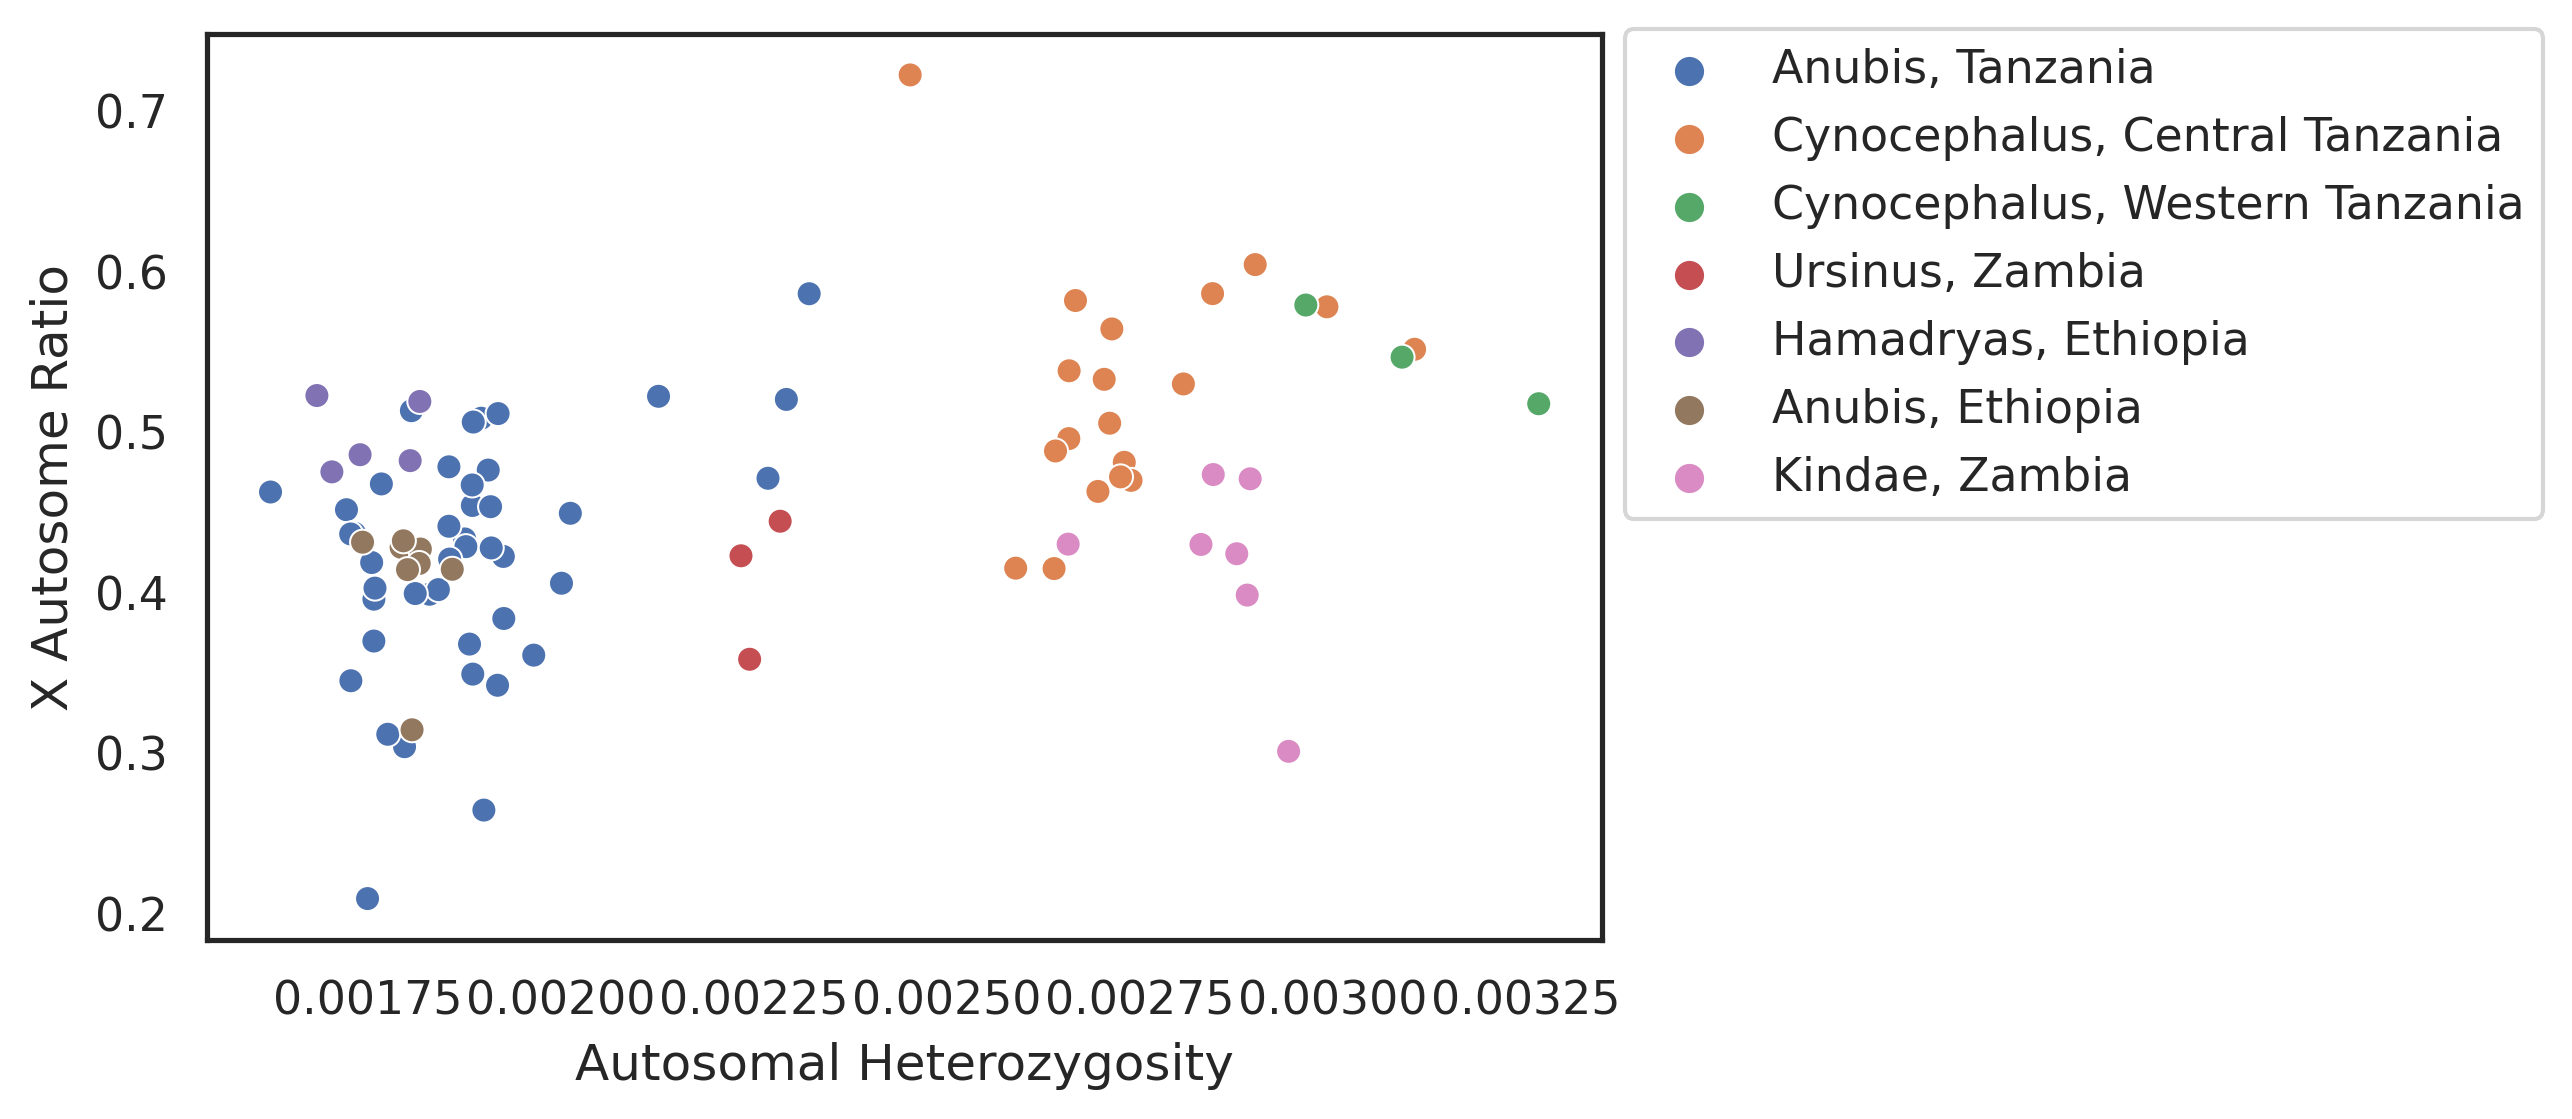

In [75]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

g = sns.scatterplot(data=chrX_vs_autosomes.loc[chrX_vs_autosomes.Origin != "Niokolo-Koba, Senegal"],
                    x="autosomal_het", y="X_autosome_ratio", hue = "C_origin")
fig = g.get_figure()
g.legend(bbox_to_anchor=(1., 1.03, 0., 0))
g.set(xlabel="Autosomal Heterozygosity", ylabel="X Autosome Ratio")

In [20]:
chrX_vs_autosomes.loc[chrX_vs_autosomes.X_autosome_ratio > 0.6]

,PGDP_ID,autosomal_het,chrX_het,chr7_het,C_origin,X_autosome_ratio,X_comp_ratio,chr7_autosome_ratio,Origin
10,PD_0213,0.002900,0.001752,0.002954,"Cynocephalus, Central Tanzania",0.604229,0.593030,1.018884,"Ruaha, Tanzania"
41,PD_0503,0.002453,0.001772,0.003034,"Cynocephalus, Central Tanzania",0.722442,0.584125,1.236795,"Ruaha, Tanzania"


In [21]:
chrX_vs_autosomes.loc[chrX_vs_autosomes.chr7_autosome_ratio > 1.2]

,PGDP_ID,autosomal_het,chrX_het,chr7_het,C_origin,X_autosome_ratio,X_comp_ratio,chr7_autosome_ratio,Origin
41,PD_0503,0.002453,0.001772,0.003034,"Cynocephalus, Central Tanzania",0.722442,0.584125,1.236795,"Ruaha, Tanzania"


In [22]:
chrX_vs_autosomes.loc[chrX_vs_autosomes.chr7_autosome_ratio < 0.7]

,PGDP_ID,autosomal_het,chrX_het,chr7_het,C_origin,X_autosome_ratio,X_comp_ratio,chr7_autosome_ratio,Origin
46,PD_0649,0.001759,0.000650,0.001193,"Anubis, Tanzania",0.369582,0.544855,0.678313,"Gombe, Tanzania"
89,PD_0789,0.002657,0.001143,0.001489,"Kindae, Zambia",0.429989,0.767205,0.560462,"Chunga, Zambia"


In [23]:
df_subset = het_df.loc[het_df.chrom.isin(["chr1", "chr6", "chr7", "chr20", "chrX"])]

<AxesSubplot:xlabel='chrom', ylabel='het_rate'>

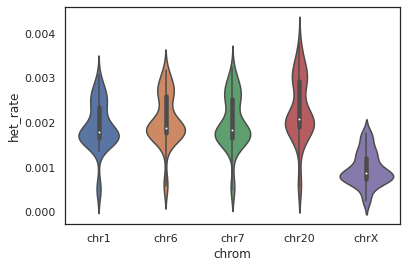

In [24]:
sns.violinplot(data=df_subset, x="chrom", y="het_rate")

<AxesSubplot:xlabel='chrom', ylabel='het_rate'>

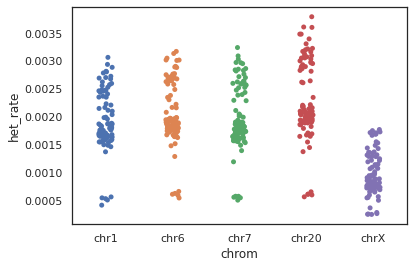

In [25]:
sns.stripplot(data=df_subset, x="chrom", y="het_rate")

In [26]:
het_df.replace([np.inf, -np.inf], np.nan)

,PGDP_ID,chrom,het_total,chr_size,C_origin,het_rate
0,PD_0199,chr1,390682,208710416,"Anubis, Tanzania",0.001872
1,PD_0200,chr1,372430,208498375,"Anubis, Tanzania",0.001786
2,PD_0203,chr1,320585,208423613,"Anubis, Tanzania",0.001538
3,PD_0205,chr1,406365,207319271,"Anubis, Tanzania",0.001960
4,PD_0206,chr1,328485,208552730,"Anubis, Tanzania",0.001575
...,...,...,...,...,...,...
1948,PD_0788,chrX,118662,134027195,"Kindae, Zambia",0.000885
1949,PD_0789,chrX,152042,133055544,"Kindae, Zambia",0.001143
1950,PD_0790,chrX,154119,133940634,"Kindae, Zambia",0.001151
1951,PD_0791,chrX,161746,132648497,"Kindae, Zambia",0.001219
